In [1]:
%load_ext autoreload
%autoreload 2

In [228]:
import csv
import json
import itertools
import collections
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from adjustText import adjust_text
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
import random_indexing as ri

In [166]:
def read_tweets(f_name):
    with open(f_name) as f:
        csv_reader = csv.reader(f)
        next(csv_reader)
        for line in csv_reader:
            tweet_id, text, language, screen_names, hashtags, is_retweet = line
            tweet_id = int(tweet_id)
            screen_names = json.loads(screen_names)
            hashtags = json.loads(hashtags)
            is_retweet = bool(is_retweet)
            
            yield tweet_id, text, language, screen_names, hashtags, is_retweet

In [167]:
vocabulary = collections.OrderedDict(
    collections.Counter(itertools.chain.from_iterable(r[1] for r in read_tweets('tweet_dump.csv')))
    .most_common()
)

vocabulary[''] = 0

In [165]:
len(vocabulary)

4679

In [8]:
D = 10_000

In [168]:
features = ri.Features(vocabulary, D=D)

In [173]:
with open('features.pickle', 'wb') as f:
    pickle.dump(features, f)

In [180]:
@dask.delayed
def load_features(f_name):
    with open('features.pickle', 'rb') as f:
        return pickle.load(f)

In [218]:
_tweets = (
    dd.read_csv(
        'tweet_dump/000*',
        converters={'is_retweet': bool, 'screen_names': json.loads},
        usecols=['tweet_id', 'text', 'screen_names'],
    )
    .set_index('tweet_id')
)

In [216]:
@dask.delayed
def index_dask(tweet, features):
    return tweet.upper

In [10]:
def index(tweets, features):
    tweet_ids = collections.OrderedDict()
    languages = {}
    screen_names = {}
    hashtags = {}

    yield tweet_ids, languages, screen_names, hashtags
    
    def update(collection, keys, tweet_id):
        for key in keys:
            collection.setdefault(key, []).append(tweet_id)
    
    for i, (tweet_id, text, language, sns, hts, is_retweet) in enumerate(tweets):
        tweet_vector = np.stack(ri.vectorize(text, window_length=3, features=features)).prod(axis=0)
    
        tweet_ids[tweet_id] = is_retweet
        if not is_retweet:
            update(languages, [language], tweet_id)
            #update(hashtags, hts, tweet_id)

        update(screen_names, sns, tweet_id)
        
        yield tweet_vector
        
        if i and (i % 10_000) == 0:
            logging.info('Processed %s tweets.', i)

In [90]:
N = 20_000
i = index(
    itertools.islice(read_tweets('tweet_dump.csv'), N),
    features,
)

tweet_ids, languages, screen_names, hashtags = next(i)

%time _ = np.vstack(i)

tweets = pd.DataFrame(_, index=tweet_ids, dtype=np.int16)
is_retweet = pd.Series(tweet_ids)

def transform(collection, name):
    return pd.DataFrame.from_records(
        ((k, v) for k, vs in collection.items() for v in vs), columns=[name, 'tweet_id'],
        index=name,
    )

by_language = transform(languages, 'languages')
by_screen_name = transform(screen_names, 'screen_names')
# by_hashtag = transform(hashtags, 'hashtags')

INFO:root:Processed 10000 tweets.


CPU times: user 3min 13s, sys: 11.3 s, total: 3min 24s
Wall time: 16min 57s


In [91]:
screen_names = (
    #by_screen_name.loc[by_screen_name.index.value_counts().nlargest(70).index]
    by_screen_name[by_screen_name.index.str.startswith('@') == True]
    .merge(tweets, left_on='tweet_id', right_index=True)
    .set_index('tweet_id', append=True)
).groupby(level='screen_names').sum()

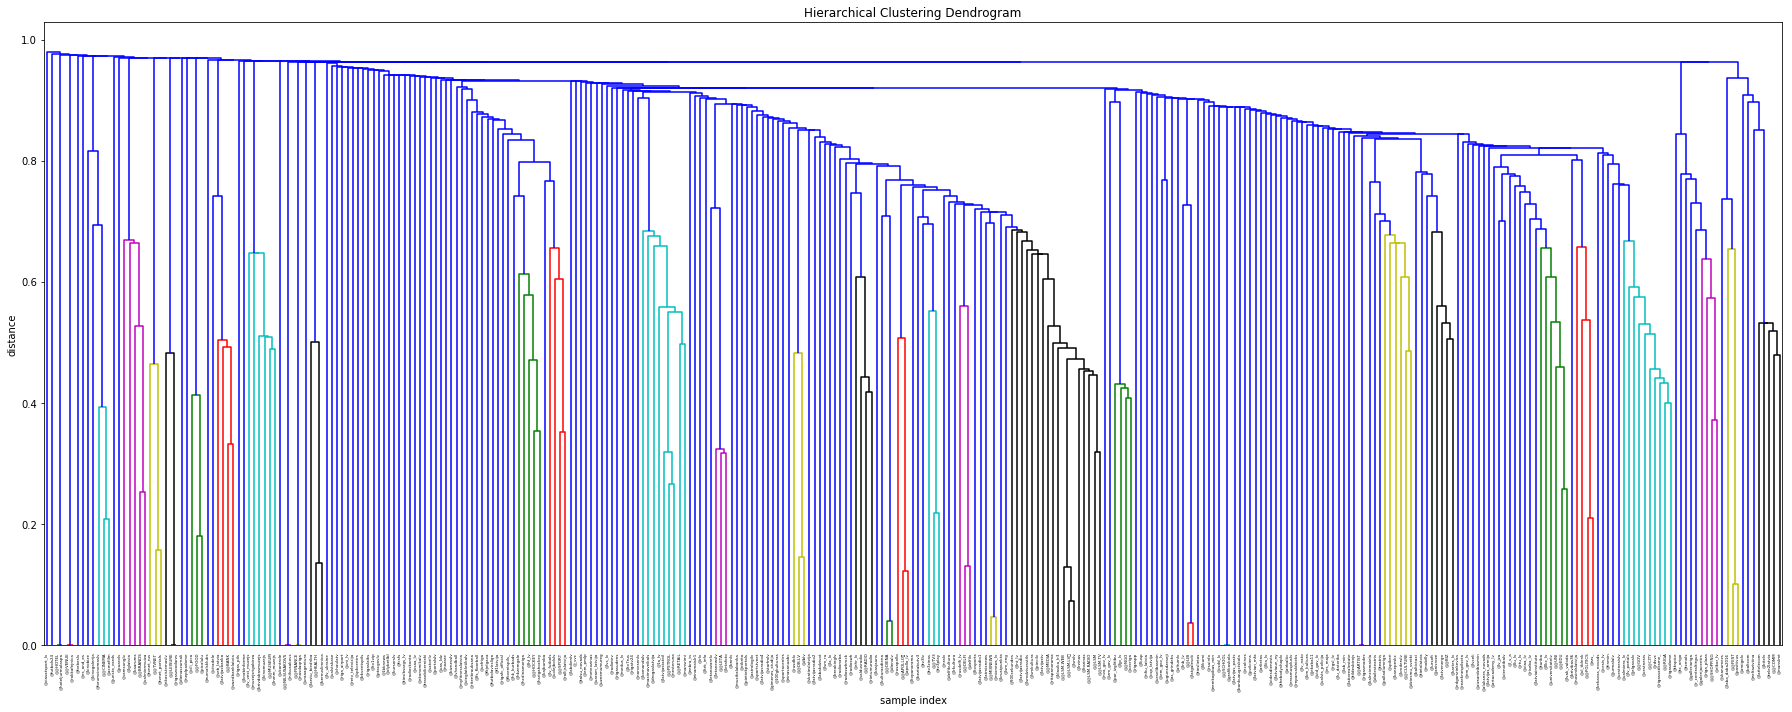

In [92]:
sn = screen_names
Z = linkage(sn, metric='cosine')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')

plt.xlabel('sample index')
plt.ylabel('distance')

dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=4.,  # font size for the x axis labels
    labels=sn.index,
)

plt.tight_layout()
plt.savefig('screen_names_clusters.pdf')

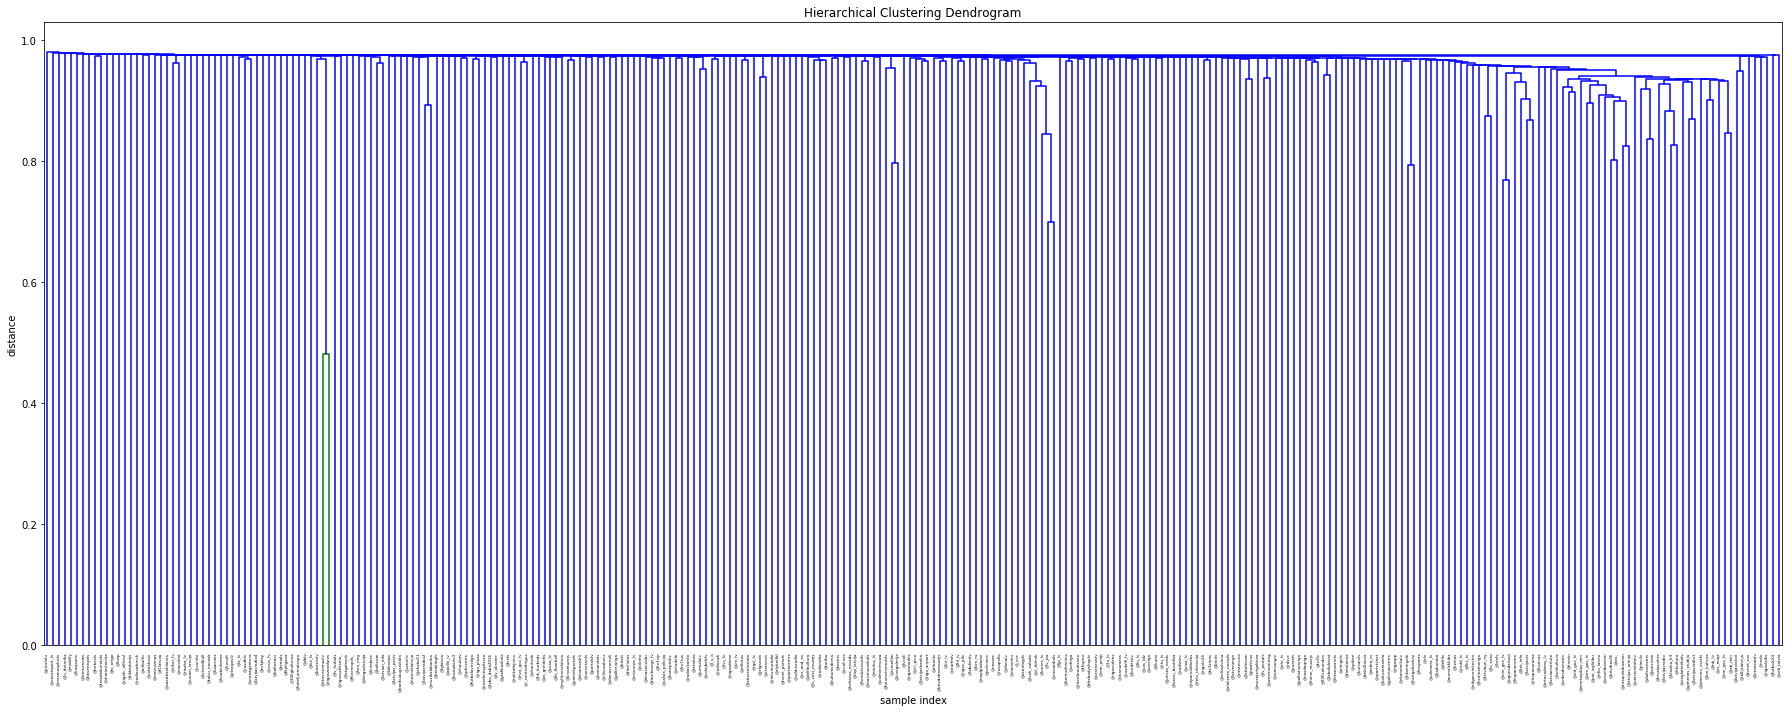

In [93]:
sn = screen_names[
    (screen_names.index.str.startswith('@') == True)
    & (screen_names.index.str.startswith('@@') == False)
]
Z = linkage(sn, metric='cosine')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')

plt.xlabel('sample index')
plt.ylabel('distance')

dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=4.,  # font size for the x axis labels
    labels=sn.index,
)

plt.tight_layout()
plt.savefig('screen_names_clusters-without-groups.pdf')

In [94]:
sn = screen_names[
    (screen_names.index.str.startswith('@') == True)
    & (screen_names.index.str.startswith('@@') == False)
]

In [115]:
mds = manifold.MDS(dissimilarity='precomputed', n_jobs=2)

sn_xy = pd.DataFrame(
    mds.fit_transform(
        pairwise_distances(sn, metric='cosine')
#         preprocessing.normalize(sn)
    ),
    index=sn.index,
)


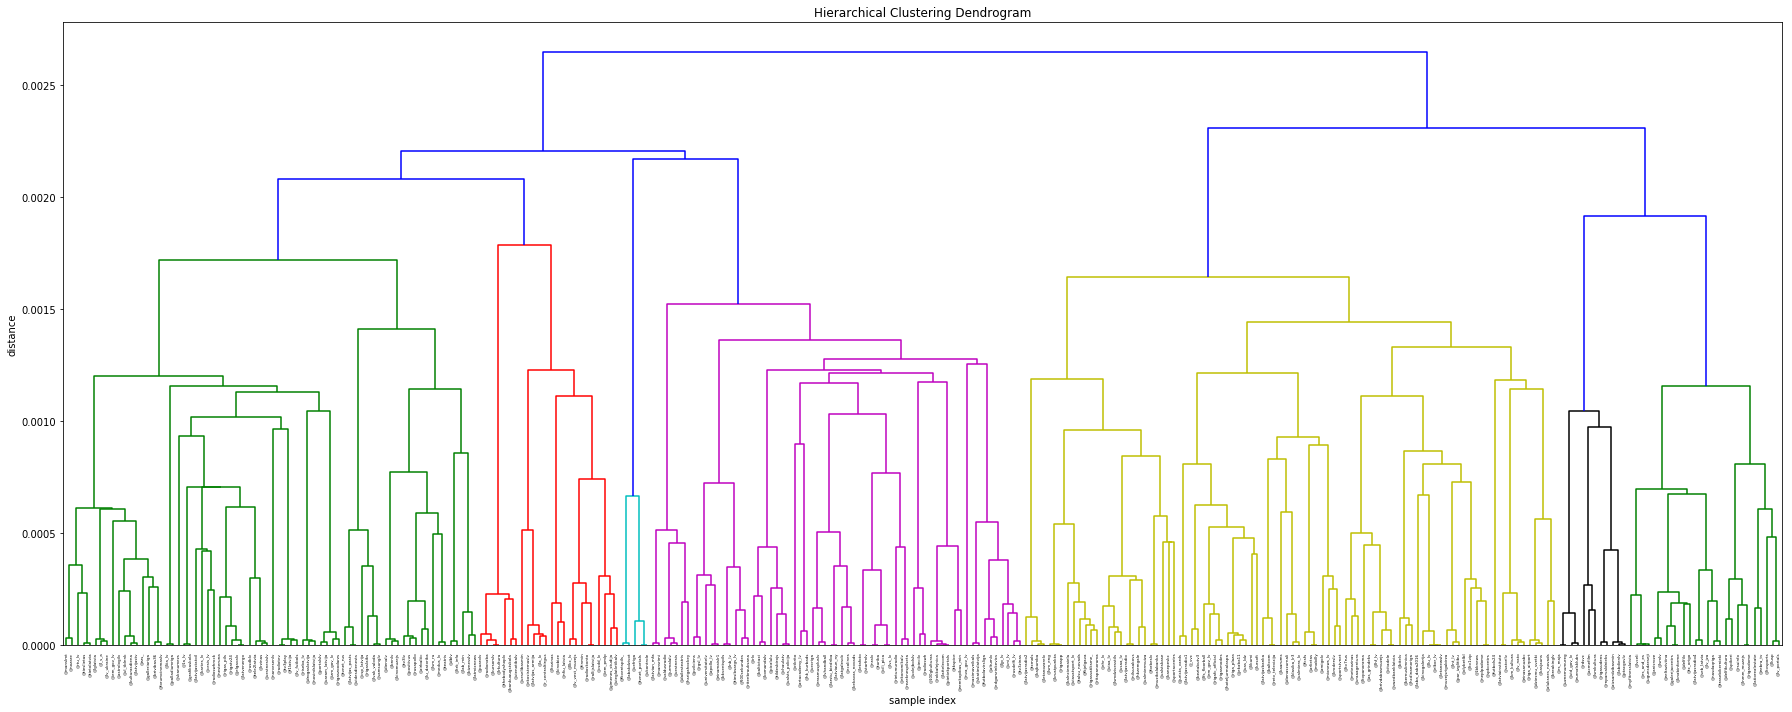

In [122]:
Z = linkage(sn_xy, metric='cosine')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')

plt.xlabel('sample index')
plt.ylabel('distance')

R = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=4.,  # font size for the x axis labels
    labels=sn.index,
)

plt.tight_layout()
plt.savefig('screen_names_clusters-without-groups-mdn.pdf')

In [120]:
clusters = fcluster(Z, 4, criterion='maxclust')

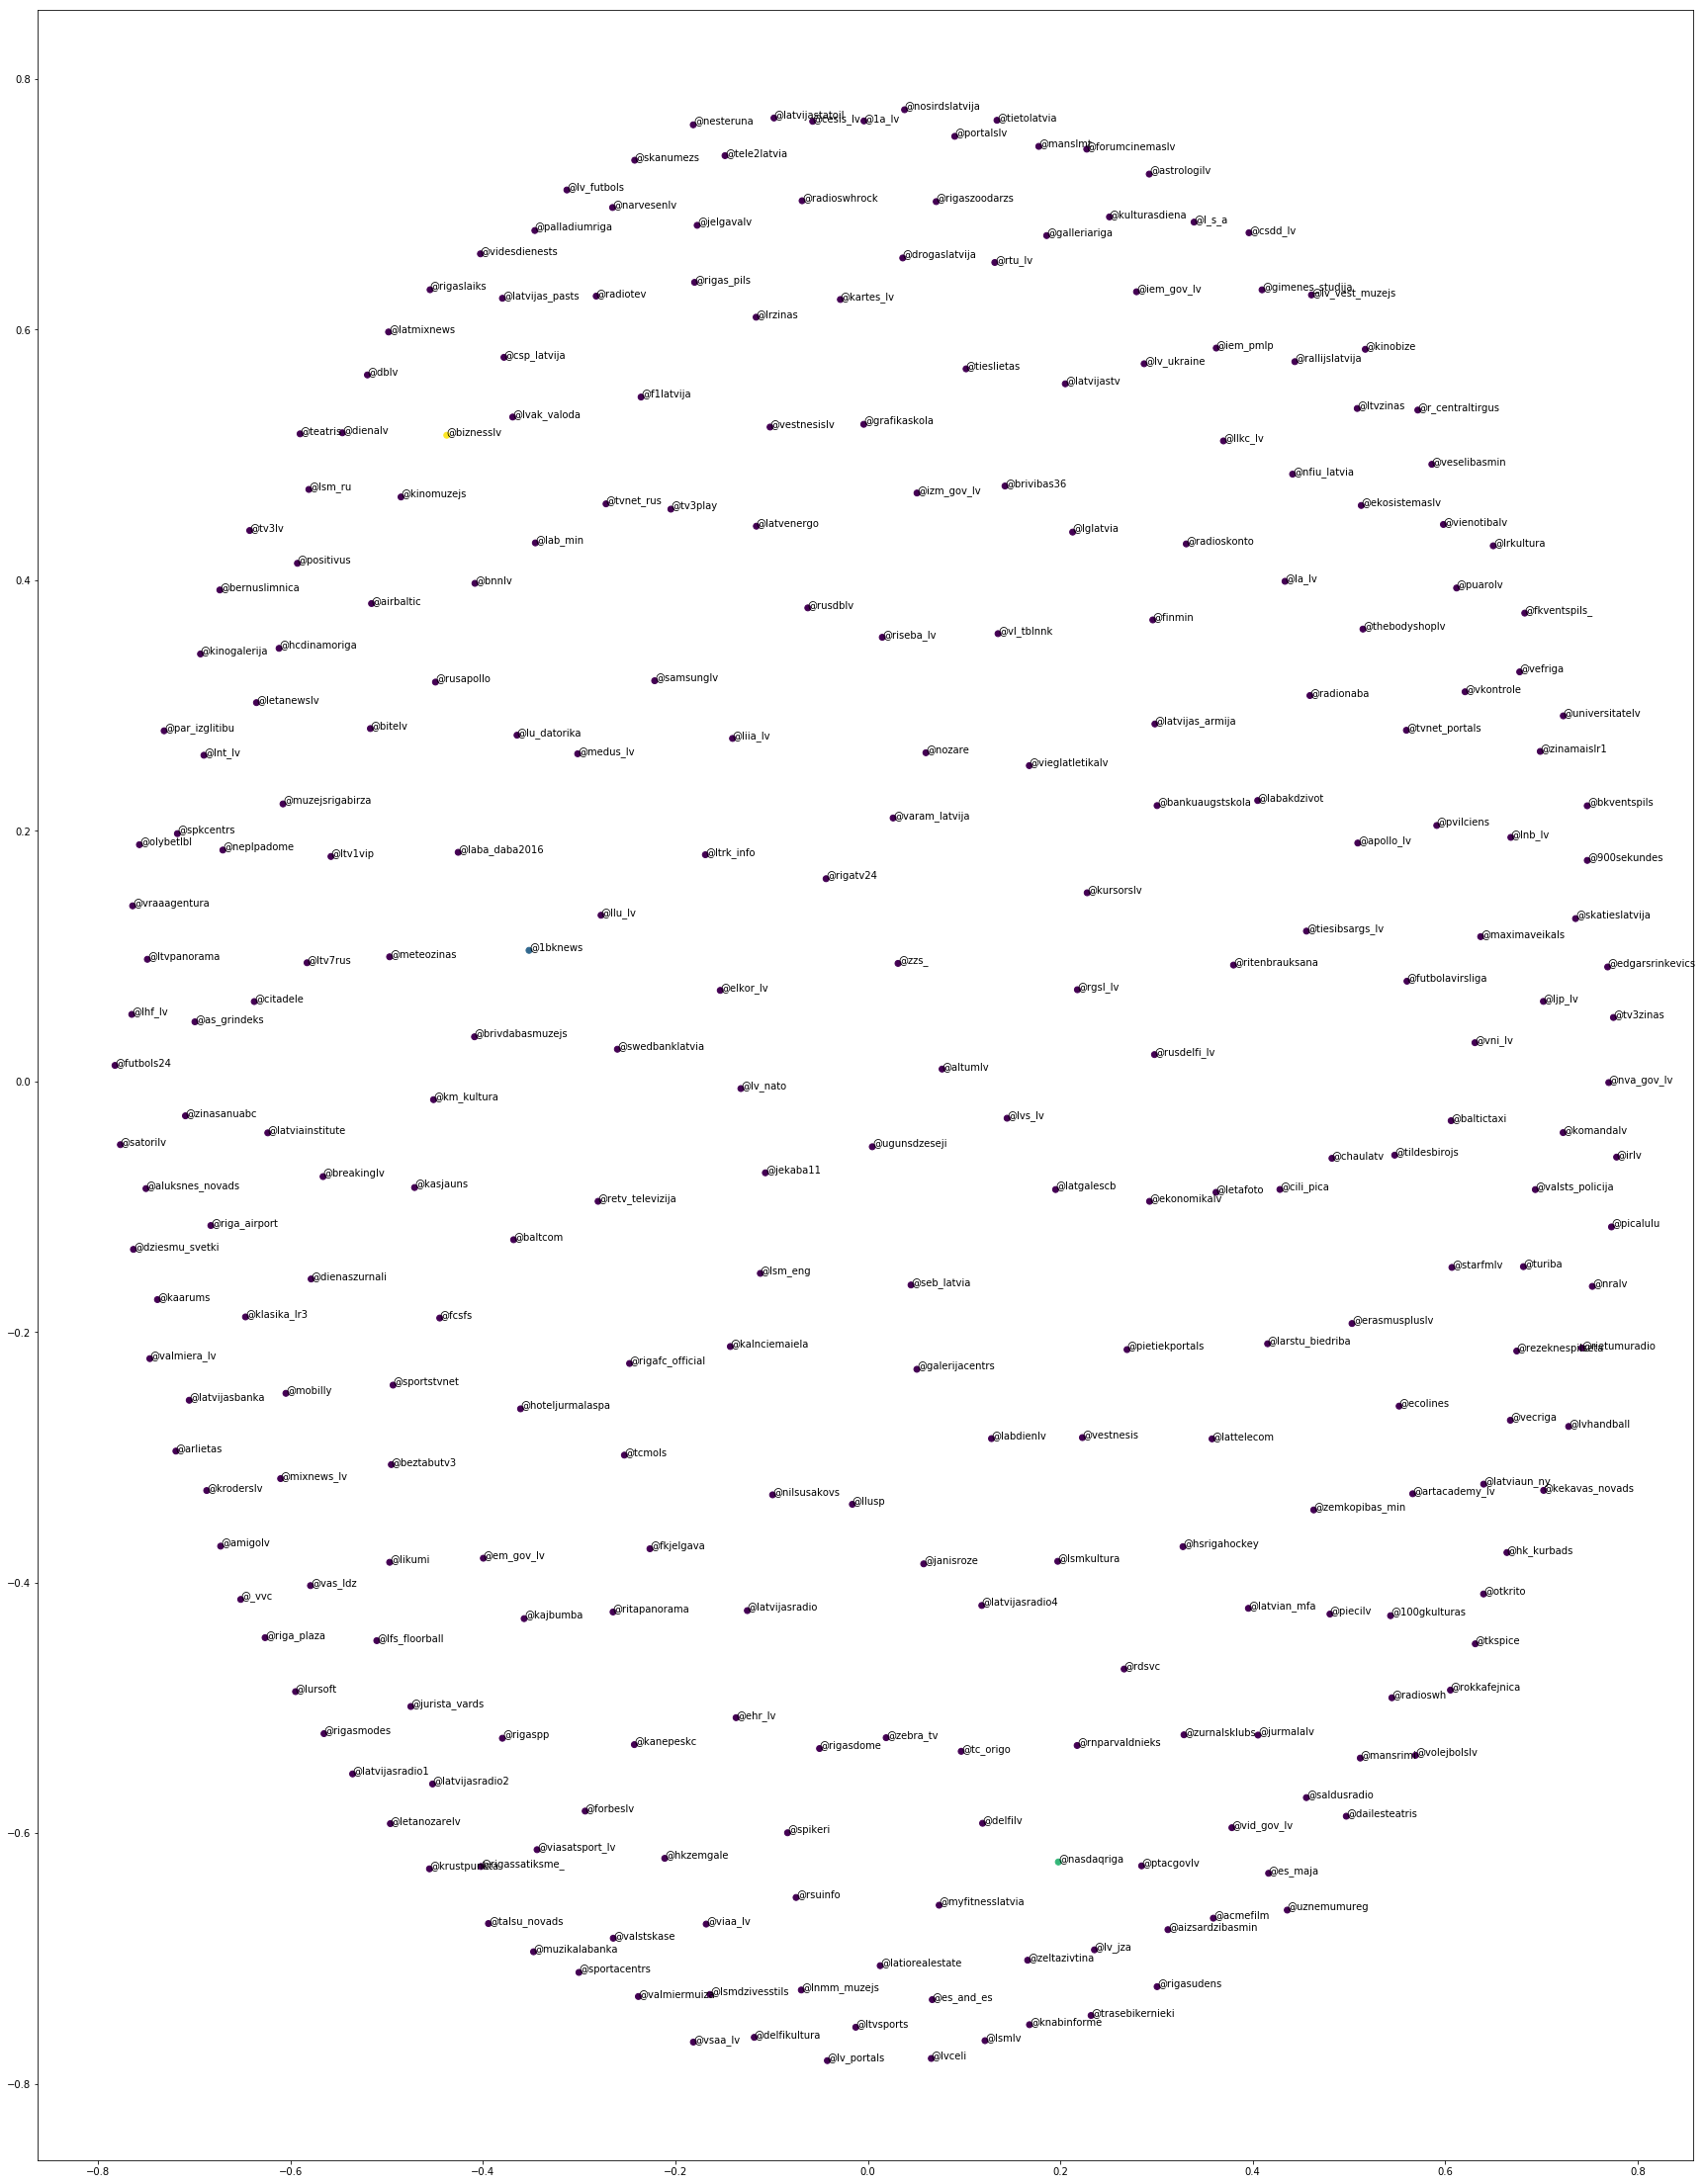

In [123]:
X = sn_xy.loc[R['ivl']]

plt.figure(figsize=(30, 40))
plt.scatter(X[0], X[1], c=clusters)
texts = X.apply(lambda r: plt.text(r[0], r[1], r.name), axis=1)

plt.show()

In [ ]:
def export_to_tf(collection, prefix):
    collection.to_csv(f'features-{prefix}.csv', sep='\t', index=False, header=False)
    collection.index.to_series().to_csv(f'metadata-{prefix}.csv', index=False)

In [ ]:
export_to_tf(screen_names[0], 'screen_names')

In [ ]:
export_to_tf(hashtags[0], 'hashtags')

In [ ]:
export_to_tf(languages[0], 'languages')